<a href="https://colab.research.google.com/github/SurajK7/ChestAI/blob/master/densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.vision import *
from torchvision.models import *
from utils import create_dfs, create_data, print_val_score, chexpert_targets, u_one_features, u_zero_features
import pandas as pd
from pathlib import Path

In [0]:
full_train_df, full_valid_df = create_dfs()
full_df = pd.concat([full_train_df, full_valid_df])

In [0]:
# function to create class labels
def feature_string(row):
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

In [0]:
#adding class labels
full_df['feature_string'] = full_df.apply(feature_string,axis = 1).fillna('')

In [0]:
data = create_data(full_df, size=320, bs=4)

In [0]:
learn = cnn_learner(data, models.densenet201, pretrained=True)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-02


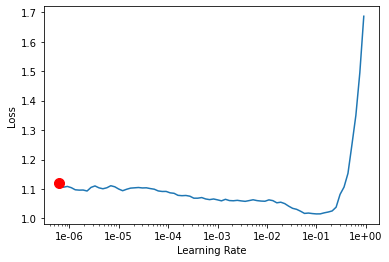

In [0]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 2e-2

In [0]:
learn.fit_one_cycle(8, slice(lr), callbacks=[callbacks.SaveModelCallback(learn, every='epoch', name='201')])

In [0]:
print_val_score(learn, full_valid_df)

201_0


0.8429914286286315
201_1


0.867527631493723
201_2


0.8322149648171635
201_3


0.863355719591001
201_4


0.8441398890260009
201_5


0.8744538737171714
201_6


0.8723674445959334
201_7


0.8769460392238108


In [0]:
learn.load('201_7')
valid_preds=learn.get_preds()
preds = valid_preds[0]
preds_df = full_valid_df.copy()

for i, c in enumerate(chexpert_targets):
    preds_df[c] = preds[:,i]

preds = preds_df.groupby(['patient','study'])[chexpert_targets].mean().values

In [0]:
np.save("preds_201", preds)